In [1]:
import numpy.matlib
import numpy as np
import cmath
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from seaborn import heatmap

from matplotlib import cm

In [2]:
j=complex(0,1)           # iota , sqrt of -1

n_side=26                # no. of atoms along an edge of the array

n=n_side**2              # for a square atomi array

c_light=3*10**8          # m/s speed of light

lamda=500 * 10**-9       # (in m) wavelength of light

w=2*np.pi*c_light/lamda

a=0.2*lamda              # interatomic distance, in terms of lamda

L=(n_side-1)*a           # length of the atomic array

k=2*np.pi/lamda          # wavenumber of incidnet light

epsilon=8.85*10**-12     # SI units, permitivitty of free space

#assuming no non-radiative losses and w_a=w
w_a=w 
lamda_a=c_light/(w_a/(2*np.pi))

alpha=3/(4*np.pi**2)*epsilon*lamda_a**3*j # polarization of an atom

#Charactersitics of incident beam: 

#polaization direction
e_x = np.array([1,0.,0.]) # the vector for x polarized field

#waist
w_0 = 0.3*np.sqrt(n)*a

#Amplitude of the electric field of the beam
E_beam_amp=1 # defaulted to 1 in the function below

In [3]:
def Greens(m,l,k,r_1,r_2):
    '''Calculates the greens function G_{ml}(r_1,r_2) using eq S3'''
    if ((r_1[0]==r_2[0])and(r_1[1]==r_2[1])and(r_1[2]==r_2[2])):    #skip the same atom
        return 0
    else:
        r_vect=r_1-r_2 
        r=np.sqrt(np.sum(np.square(r_vect)))
        
        if m==l: # serves as kronecker delta
            t1=(1+ (j*k*r-1)/((k*r)**2))
        else:
            t1=0
        t2=(-1 + (3-3*k*r*j)/(k*r)**2)*r_vect[m]*r_vect[l]/r**2
        t3=(np.cos(k*r)+j*np.sin(k*r))*(t1+t2)/(4*np.pi*r)  #eq S3
        return t3

$$G_{ij}(k,\textbf{r}_1,\textbf{r}_2)=\frac{e^{ikr}}{4\pi r}\left[\left(1+\frac{ikr-1}{k^2r^2}\right)\delta_{ij}+\left(-1+\frac{3-3ikr}{k^2r^2}\right)\frac{r^ir^j}{r^2}\right]$$
where $\textbf{r}=\textbf{r}_1-\textbf{r}_2$, $r=\left|{\textbf{r}}\right|$ and $r^i=e_i.\textbf{r}$

In [4]:
def gaussian_beam(x,y,z,w_0,lamda,e_L,E_0_amp=1):
    '''returns the incident gaussian beam at the point (x,y,z)\
    given byy equation eq. S55 \
    For z=0, exp(1/R(z)) term has been set to 0\
    lamda is the wavelength of the beam\
    w_0 is the beam waist at the focal point\
    e_L is the polarization vector\
    E_0_amp is the amplitude '''
    #wave number k
    k = 2*np.pi/lamda
    
    #below constants are as defined in the paper eq. S56
    z_R = np.pi*w_0**2/lamda 
    w_z = w_0*np.sqrt(1+(z/z_R)**2)

    phi_z = np.arctan(z/z_R)

    #Rz tends to infinity as z tends to 0. Which is why this ifelse condition is required \
    #to explicitly set the term involving  1/R to zero
    if z == 0:
        R_z = 1e100
        theta=k*z - phi_z #theta is the coeff of the exponential form of the complex number 
    else:
        R_z = z*(1+(z_R/z)**2)
        #This is the coeff of i in the exponential. 
        theta = k*z - phi_z + k*(x**2+y**2)/(2*R_z)
    
    #Following are the magnitude, real part and imaginary part respectively of the electric field of incident light
    E_0 = (E_0_amp*(w_0/w_z)*np.exp(-1*(x**2+y**2)/(w_z**2))*(np.cos(theta)+j*np.sin(theta)))*e_L # eq S55

    return E_0 #the final incident beam at (x,y,z) 

Gaussian beam equation:

$$\textbf{E}_0\left(x',y',z'\right) = E_0\textbf{e}_L\frac{w_0}{w(z')}e^{ikz'}e^{-i\phi(z')}e^{-\frac{x'^2+y'^2}{w^2(z')}}e^{ik\frac{x'^2+y'^2}{2R(z')}}$$
    
with the parameters being,
    
$$w(z)=w_0\sqrt{1+\left(\frac{z}{z_R}\right)^2},   z_R=\frac{\pi w_0^2}{\lambda},    R\left(z\right)=z\left[1+\left(\frac{z_R}{z}\right)^2\right],    \phi \left(z\right) = \arctan\left(\frac{z'}{z_R}\right)$$

Plot the variation of the electric field of the beam  with z axis at x=0,y=0

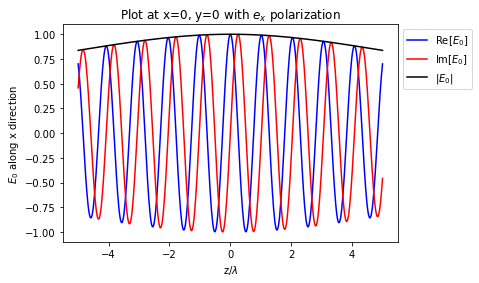

In [5]:
#position of x,y at which values of electric field along z axis are plotted
x = 0
y = 0

#initialization
#range of z
z = np.arange(-5, 5+10/500, 10/500)
E_incident_along_z=np.zeros(shape=(len(z),3),dtype=np.complex_)
for i in range(0,len(z)):
    E_incident_along_z[i]= gaussian_beam(x,y,z[i]*lamda,w_0,lamda,e_x,E_beam_amp)

plt.plot(z,E_incident_along_z[:,0].real,label='Re[$E_0$]',color='blue') #plotting only x component as remaining components are 0 because of polarization
plt.plot(z,E_incident_along_z[:,0].imag,label='Im[$E_0$]',color='red')
plt.plot(z,abs(E_incident_along_z[:,0]),label='|$E_0$|',color='black')
plt.xlabel('z/$\lambda$')
plt.ylabel('$E_0$ along x direction')
plt.legend(bbox_to_anchor=(1,1))
plt.title('Plot at x=0, y=0 with $e_x$ polarization')
# function to show the plot
plt.show()


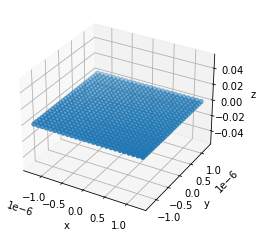

In [6]:
R=np.zeros(shape=(n,3)) 
for i in range(0,n):
    R[i]=((-L/2+a*(i%n_side)),(L/2-a*int((i/n_side))),0)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
#ax.view_init(3*10**-7,2*10**-7,'x')
ax.scatter3D(R[:,0],R[:,1],R[:,2],cmap="Greens")

In [7]:
#Field value at points where atoms are placed i.e. z=0
E_0_at_atoms = np.zeros(shape=(n,3),dtype=np.complex_)

#position of atoms is at (x,y,0)

#The order is as explained in the final cell of gaussian_beam
for i in range(0,n):
      E_0_at_atoms[i] = gaussian_beam(R[i][0],R[i][1],R[i][2],w_0,lamda,e_x,E_beam_amp)
        
#E_0_at_atoms is a (n ,3) matrix, with n running over indices of atoms, 3 denoting the component of electric field at the atom 

1.250000000000002e-06
-1.2500000000000003e-06


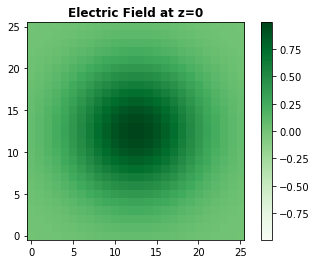

In [8]:
#Trying out different plots
x_axis=np.arange(-L/2,L/2+a,a)
y_axis=np.arange(L/2,-L/2+a,a)
print(x_axis.max())
print(x_axis.min())
z_min, z_max = -np.abs(E_0_at_atoms.real[:,0]).max(), np.abs(E_0_at_atoms.real[:,0]).max()

fig, ax = plt.subplots()

c = plt.imshow(E_0_at_atoms.real[:,0].reshape(n_side,n_side), cmap ='Greens', vmin = z_min, vmax = z_max,   interpolation ='nearest', origin ='lower')\
              # extent =[x_axis.min(), x_axis.max(), y_axis.min(), y_axis.max()],\
             
plt.colorbar(c)
 
plt.title('Electric Field at z=0' , fontweight ="bold")
plt.show()


Final 3N vector of electric field (magnitude, real part and imaginary part are separated). Here, the order goes as\

(-(n-1)*a/2,-(n-1)*a/2); (-(n+1)*a/2,-(n-1)*a/2); (-(n+3)*a/2,-(n-1)*a/2); ... ((n-1)*a/2,-(n-1)*a/2);  \
(-(n-1)*a/2,-(n+1)*a/2); ...                                                   ((n-1)*a/2,-(n+1)*a/2);\
.\
.\
.\
(-(n-1)*a/2,(n-1)*a/2); ...                                                    ((n-1)*a/2,(n-1)*a/2)\
\
where (x,y) represent coordinates of the atoms.



In [10]:
G=np.empty(shape=(n,3,n,3),dtype=np.complex_)

#Calculating the G matrix to find the field at the atoms in n_1,3,n_2,3 form, where n_1 is index of r1, n_2 is index of r2
# this g is used in eq S54
for r_1 in range(0,n):      
        for m in range(0,3):
              for r_2 in range(0,n):
                    for l in range(0,3):
                        G[r_1,m,r_2,l]=Greens(m,l,k,R[r_1],R[r_2])# using eq S3
                   

The block below performs the task of finding the field at the atoms using eq S $54$


$$\overline{E} = E_i(\textbf{r}_n) = \left[1-4\pi^2\frac{\alpha}{\epsilon_0\lambda^3}\lambda\overline{\overline{\mathbb{G}}}\right]^{-1}\overline{E}_0$$

In [11]:
# G is in 3n * 3n matrix  form  
G_M=G.reshape(3*n,3*n)

# E_0_at_atoms is the incident electric field at atoms
E_0_V=E_0_at_atoms.reshape(3*n,1) # reshape E_n so that it can be multiplied by a 3n*3n  matrix

# Calculating total electric fields at the atoms
I_M=np.identity(3*n,dtype=np.complex_)

INVERSE_M=np.linalg.inv(I_M-(4*(np.pi**2)*alpha/(epsilon*lamda**2)*G_M)) # the inverse term in eq S54

E_at_atoms_V=np.matmul(INVERSE_M,E_0_V) # eq S54 

E_at_atoms=E_at_atoms_V.reshape(n,3)

 The block below calculates the field at any point, using equation S5
$$E_i(\textbf{r}) = E_{0,i}(\textbf{r}) + 4\pi^2\frac{\alpha}{\epsilon_o\lambda^3}\sum_j\sum_n\lambda
    G_{ij}(k,\textbf{r},\textbf{r}_n)E_j(\textbf{r}_n)$$

In [12]:
# Function which returns, incident, scattered and total electric field at position x, y, z
def E(x,y,z,E_at_atoms_V):   
    '''returns the incident electric field, scattered electric field and total electric field at the point (x,y,z)\
    E_at_atoms_V is the field at the atoms'''
    Greens_at_r = np.zeros(shape=(3,n,3),dtype=np.complex_)
    E_0_at_r = gaussian_beam(x,y,z,w_0,lamda,np.array([1,0,0]))# incident electric field
  
    for i in range(0,3):
        for m in range(0,3):
            for atoms_index in range(0,n):
                Greens_at_r[i,atoms_index,m]=Greens(i,m,k,(x,y,z),R[atoms_index])
                
    Greens_at_r_M = Greens_at_r.reshape(3,3*n)
    # the scattered electric field
    Scattered_field = (4*(np.pi**2)*alpha/(epsilon*lamda**2)) *np.matmul(Greens_at_r_M,E_at_atoms_V).reshape(3,)\
    #total electric field
    E_space = np.add(E_0_at_r , Scattered_field)
    
    return E_0_at_r, Scattered_field, E_space # incident field, scattered field, total field

This block find the field along the z-axis for a particulra x,y on the atomic plane

In [13]:
x_find,y_find=0*a,0*a # the electric field is found in direction perpendicular to x_find,y_find in the atomic array's plane 

perpendicular_direction=np.arange(-5,5+1/100,1/100) #z/lamda array i.e z=-5*lamda to 5#lamda

E_perpendicular_to_array=np.zeros(shape=(len(perpendicular_direction),3),dtype=np.complex_)

Scattered_perpendicular_to_array=np.zeros(shape=(len(perpendicular_direction),3),dtype=np.complex_)

Incident_perpendicular_to_array=np.zeros(shape=(len(perpendicular_direction),3),dtype=np.complex_)

for i in range(0,len(perpendicular_direction),1):
     Incident_perpendicular_to_array[i],Scattered_perpendicular_to_array[i], E_perpendicular_to_array[i]=E(x_find,y_find,lamda*perpendicular_direction[i],E_at_atoms_V)


In [14]:
#renaming the arrays
I=Incident_perpendicular_to_array 
T=E_perpendicular_to_array
S=Scattered_perpendicular_to_array

Text(0, 0.5, '$|E_{x}/E_0|^2$')

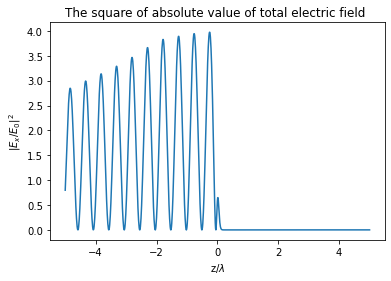

In [15]:
# the absolute value of the total electric field

plt.plot(perpendicular_direction,np.square(abs(T[:,0]/E_beam_amp))) 
plt.title('The square of absolute value of total electric field ')
plt.xlabel('z/$\lambda$')
plt.ylabel('$|E_{x}/E_0|^2$')

Text(0, 0.5, '$Im[E_{x}]$')

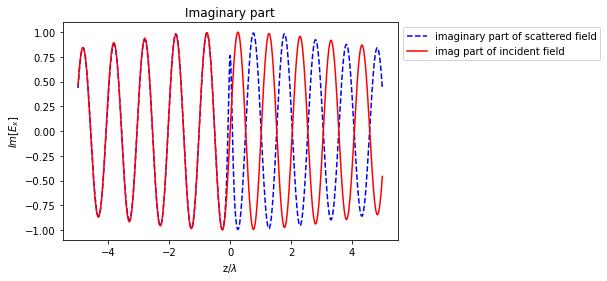

In [16]:
#the imaginary part of the incident and scattered fields
plt.plot(perpendicular_direction,S[:,0].imag,'b--',label='imaginary part of scattered field',)
plt.plot(perpendicular_direction,I[:,0].imag,color='red',label='imag part of incident field')

plt.legend(bbox_to_anchor=(1,1))
plt.title('Imaginary part')
plt.xlabel('z/$\lambda$')
plt.ylabel('$Im[E_{x}]$')

Text(0, 0.5, '$Re[E_{x}]$')

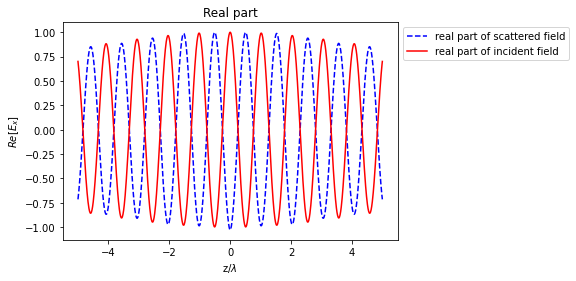

In [17]:
# the real parts of the incident and scattered field

plt.plot(perpendicular_direction,S[:,0].real,'b--',label='real part of scattered field',)
plt.plot(perpendicular_direction,I[:,0].real,color='red',label='real part of incident field')

plt.legend(bbox_to_anchor=(1,1))
plt.title('Real part')
plt.xlabel('z/$\lambda$')
plt.ylabel('$Re[E_{x}]$')

In [18]:
y_level=0
x_axis=np.arange(-2,2+1/50,1/10)
z_axis=np.arange(-2,2+1/50,1/10)
E_grid=np.zeros(shape=(len(x_axis),len(z_axis),3,3),dtype=np.complex_)

xs,zs=np.meshgrid(x,y,sparse=True,indexing='xy')

for i in range(0,len(x_axis)):
    for l in range(0,len(z_axis)):
    
        E_grid[i,l,0],E_grid[i,l,1],E_grid[i,l,2]=E(x_axis[i]*lamda,y_level,z_axis[l]*lamda,E_at_atoms_V)

# E_grid stores the values at the point in the format (x,z,field,component)
#field runs from 0 to 2, 0 is the incident field, 1 is the scattered field, 2 is the total field
#component refers  to the x,y,z component of a particular field at a particular point

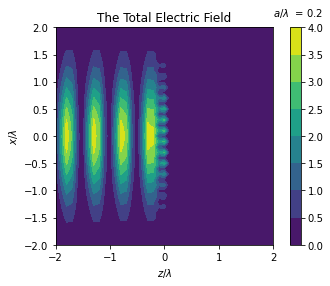

In [32]:
h = plt.contourf(z_axis,x_axis,np.square(abs(E_grid[:,:,2,0]/E_beam_amp)) )
plt.axis('scaled')
plt.title('The Total Electric Field')
plt.xlabel('$z/\lambda$')
plt.ylabel('$x/\lambda$')
plt.colorbar()
plt.text(2,2.2,f'$a/ \lambda$  = {(a/lamda)}')
plt.show()